In [1]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import model_bs as mdl
import data_utils as du
import dataset as ds

token_to_idx, idx_to_token = du.load_or_create_vocabulary(csv_paths=[], cache_path="/home/md_halim_mondol/LSTM_VAE_Paper/vocab.json",test_smiles=None)

assert token_to_idx["<PAD>"] == 0
assert token_to_idx["<SOS>"] == 2
assert token_to_idx["<EOS>"] == 3

model = mdl.LSTM_VAE_Trans(
        vocab_size=len(token_to_idx),
        d_model=256,
        latent_dim=64,
        pad_idx=0,
        sos_idx=2,
        eos_idx=3,
        enc_layers=7,
        dec_layers=7,
        nhead=8,
        dropout=0.05,
        max_len=160,
        dim_feedforward=1024)
model.load_state_dict(torch.load("/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/best_model.pth", map_location="cpu"))

# unwrap DataParallel if needed, and get device
m = model.module if isinstance(model, nn.DataParallel) else model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
m = model  # (no DP wrapping here)
m.eval()

[vocab] loaded cached vocabulary from /home/md_halim_mondol/LSTM_VAE_Paper/vocab.json (69 tokens)


/var/tmp/ipykernel_214229/1521643811.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/md_halim_mondol/LSTM_VAE_Paper/checkpoints/

LSTM_VAE_Trans(
  (encoder): EncoderBiLSTM(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (emb_do): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 128, num_layers=7, batch_first=True, dropout=0.05, bidirectional=True)
    (out_do): Dropout(p=0.05, inplace=False)
    (seq_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pool_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (to_mu): Linear(in_features=256, out_features=64, bias=True)
  (to_logvar): Linear(in_features=256, out_features=64, bias=True)
  (latent_to_token): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )

In [2]:
# Example configuration dictionary
cfg = {"test_files": ["/home/md_halim_mondol/Data/union.csv"], "seq_length": 160, "latent_dim": 64}
smiles = du.load_smiles_list([cfg["test_files"][0]], n_samples=18000, shuffle=False)
test_ds = ds.SMILESDataset(smiles, seq_length=cfg["seq_length"], token_to_idx=token_to_idx,augmentor=None, augment_train=False)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [3]:
latents = []
with torch.no_grad():
    for inp, tgt in test_dl:                 # dataset returns (seq, seq)
        inp, tgt = inp.to(device), tgt.to(device)
        # forward with TF returns (logits, mu, logvar)
        _, mu, _ = m(inp, tgt=tgt, teacher_forcing=True)
        latents.append(mu.cpu().numpy())

Z = np.concatenate(latents, axis=0)          # [N, latent_dim]
print("Latents shape:", Z.shape)

/home/md_halim_mondol/anaconda3/envs/cheminf/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Latents shape: (18000, 64)


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, QED
import numpy as np
import pandas as pd

def props_from_smiles(s):
    m = Chem.MolFromSmiles(s)
    if m is None:
        return None
    return dict(
        MW=Descriptors.MolWt(m),
        LogP=Descriptors.MolLogP(m),
        TPSA=rdMolDescriptors.CalcTPSA(m),
        HBA=rdMolDescriptors.CalcNumHBA(m),
        HBD=rdMolDescriptors.CalcNumHBD(m),
        AromRings=rdMolDescriptors.CalcNumAromaticRings(m),
        RotBonds=rdMolDescriptors.CalcNumRotatableBonds(m),
        HeavyAtoms=m.GetNumHeavyAtoms(),
        Fsp3=rdMolDescriptors.CalcFractionCSP3(m),
        QED=QED.qed(m),
    )

prop_rows = []
for s in smiles:
    d = props_from_smiles(s)
    prop_rows.append(d)

prop_df = pd.DataFrame(prop_rows)   # may contain NaNs if SMILES invalid
from IPython.display import display

with pd.option_context("display.max_columns", None, "display.width", None):
    display(prop_df.head())


,MW,LogP,TPSA,HBA,HBD,AromRings,RotBonds,HeavyAtoms,Fsp3,QED
0,230.676,1.4199,49.74,3,0,1,0,14,0.125,0.633710
1,468.383,5.0325,85.97,6,1,4,3,34,0.120,0.257875
2,468.383,5.0325,85.97,6,1,4,3,34,0.120,0.257875
3,441.163,6.1178,35.53,3,0,3,0,29,0.050,0.182667
4,481.287,5.7976,100.88,6,2,5,3,33,0.040,0.338062


In [5]:
valid_mask = prop_df.notna().all(axis=1).values
Z_ok = Z[valid_mask]
smiles_ok = [s for s, keep in zip(smiles, valid_mask) if keep]
props_ok = prop_df.loc[valid_mask].reset_index(drop=True)
print("Kept:", len(smiles_ok), "of", len(smiles))

Kept: 18000 of 18000


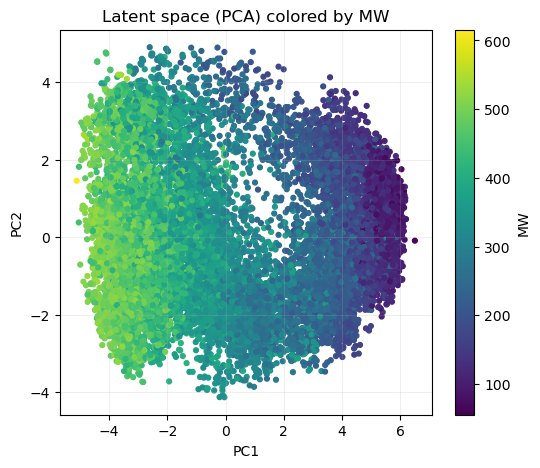

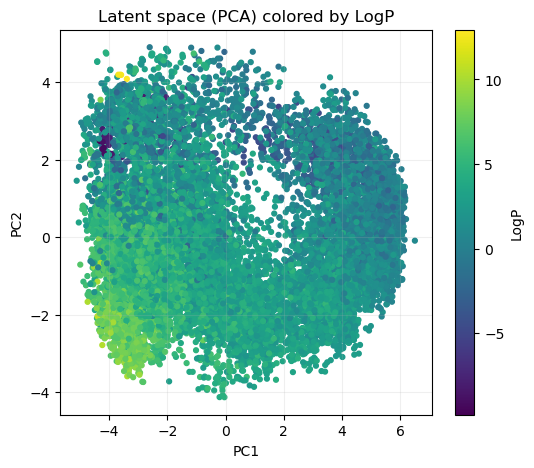

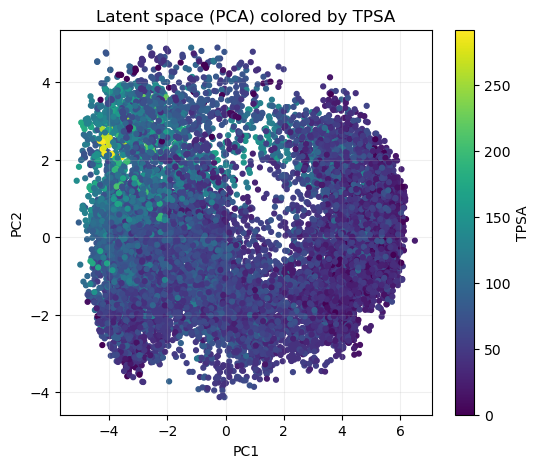

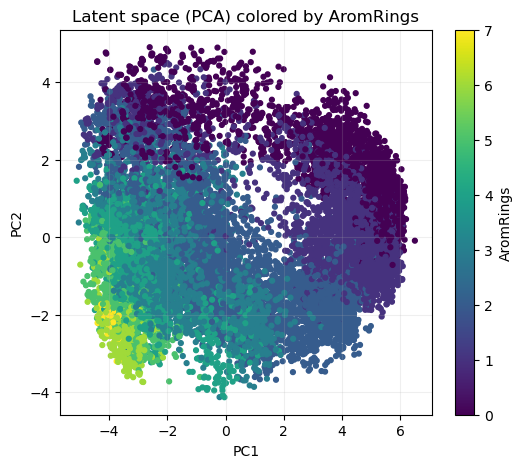

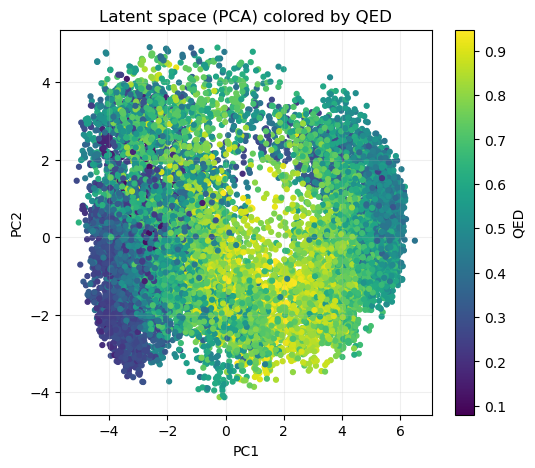

In [6]:
from sklearn.decomposition import PCA
XY = PCA(n_components=2).fit_transform(Z_ok)

def scatter_by(colname):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(XY[:,0], XY[:,1], c=props_ok[colname].values, s=12, cmap="viridis")
    plt.colorbar(sc, label=colname)
    plt.title(f"Latent space (PCA) colored by {colname}")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(alpha=0.2); plt.show()

# Try a few:
for col in ["MW", "LogP", "TPSA", "AromRings", "QED"]:
    scatter_by(col)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import torch.nn as nn, torch.optim as optim

results = []

# standardize z once using train split per property (to avoid leakage)
def fit_eval_mlp(X, y, latent_dim, device, epochs=200):
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=0)

    mu = Xtr.mean(0, keepdims=True)
    sd = Xtr.std(0, keepdims=True) + 1e-8
    Xtr_n = (Xtr - mu)/sd; Xva_n = (Xva - mu)/sd

    Xt = torch.tensor(Xtr_n, dtype=torch.float32, device=device)
    Xv = torch.tensor(Xva_n, dtype=torch.float32, device=device)
    yt = torch.tensor(ytr[:,None], dtype=torch.float32, device=device)
    yv = torch.tensor(yva[:,None], dtype=torch.float32, device=device)

    head = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, 1)).to(device)
    opt = optim.AdamW(head.parameters(), lr=6e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    head.train()
    for _ in range(epochs):
        opt.zero_grad()
        pred = head(Xt)
        loss = loss_fn(pred, yt)
        loss.backward()
        opt.step()

    head.eval()
    with torch.no_grad():
        pred = head(Xv).cpu().numpy().ravel()

    return mean_absolute_error(yva, pred), r2_score(yva, pred)

# loop properties
for col in props_ok.columns:
    y = props_ok[col].values.astype(np.float32)

    # Ridge (linear)
    Xtr, Xva, ytr, yva = train_test_split(Z_ok, y, test_size=0.2, random_state=0)
    # standardize features for ridge
    mu = Xtr.mean(0, keepdims=True); sd = Xtr.std(0, keepdims=True) + 1e-8
    r = Ridge(alpha=1.0)
    r.fit((Xtr - mu)/sd, ytr)
    pred_lin = r.predict((Xva - mu)/sd)
    mae_lin = mean_absolute_error(yva, pred_lin)
    r2_lin  = r2_score(yva, pred_lin)

    # MLP
    mae_mlp, r2_mlp = fit_eval_mlp(Z_ok, y, cfg["latent_dim"], device, epochs=1000)

    results.append((col, mae_lin, r2_lin, mae_mlp, r2_mlp))

res_df = pd.DataFrame(results, columns=["property", "MAE_ridge", "R2_ridge", "MAE_mlp", "R2_mlp"])
display(res_df.sort_values("R2_mlp", ascending=False))

,property,MAE_ridge,R2_ridge,MAE_mlp,R2_mlp
7,HeavyAtoms,0.976176,0.982632,0.625722,0.992465
5,AromRings,0.269585,0.944913,0.119095,0.988138
8,Fsp3,0.086169,0.812021,0.036212,0.962908
0,MW,21.408804,0.950802,22.959970,0.945140
1,LogP,0.997810,0.740740,0.553602,0.911911
3,HBA,0.963926,0.665809,0.493111,0.908412
6,RotBonds,0.813320,0.703361,0.445048,0.899637
9,QED,0.089336,0.660483,0.048096,0.885182
4,HBD,0.707179,0.557485,0.351609,0.883371
2,TPSA,15.552473,0.655286,9.233128,0.872175


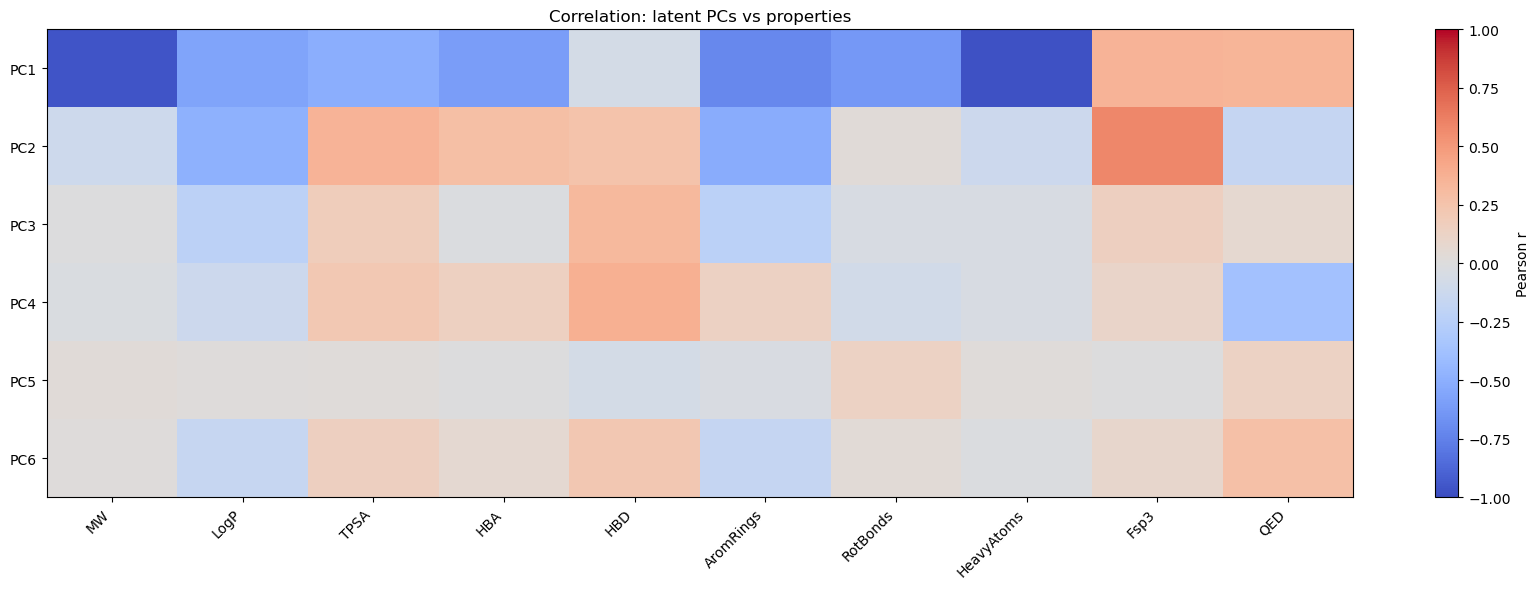

In [8]:
# PCs of Z
pca_full = PCA(n_components=min(20, Z_ok.shape[1]))
Z_pc = pca_full.fit_transform(Z_ok)[:, :6]   # first 6 PCs
pc_df = pd.DataFrame(Z_pc, columns=[f"PC{i+1}" for i in range(Z_pc.shape[1])])

corr = pd.concat([pc_df, props_ok.reset_index(drop=True)], axis=1).corr().loc[pc_df.columns, props_ok.columns]

plt.figure(figsize=(1.5*len(props_ok.columns)+2, 6))
im = plt.imshow(corr.values, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Pearson r")
plt.yticks(range(len(pc_df.columns)), pc_df.columns)
plt.xticks(range(len(props_ok.columns)), props_ok.columns, rotation=45, ha="right")
plt.title("Correlation: latent PCs vs properties")
plt.tight_layout(); plt.show()